# Distance Based Method

There are lots of these methods. In my opinion they are all quote obtuse, that is they require some methods which almost feel like brute force.  

Some correlation needs to be found and from that some transformation can be derived. There are a few good correlation methods in scymy and numpy.  
https://stackoverflow.com/questions/24034839/valueerror-resizing-an-ndarray  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html  

Note on correlate2d:
> The output is the full **discrete linear cross-correlation** of the inputs. 

In [39]:
import imageio
import math

import numpy as np
import scipy as sp

from operator import prod

## Some different similarity measurements

These similarity measurements do not work nicely but as a proof of concept they're interesting. Each one is just a little off what correlate2d can deliver.

In [229]:
def fill_fn(fn, size):
    name = fn.__name__
    if name == 'NCC':
        return np.zeros(size)
    elif name == 'SSD' or name == 'SAD':
        return np.full(size, np.inf)

def convolve(im, template, op):
    h_len, w_len = im.shape
    th, tw = template.shape
    offset_h, offset_w = (int(th/2), int(tw/2))
    op_res = fill_fn(op, (h_len, w_len))
    for i in range(h_len-th+1):
        for j in range(w_len-tw+1):
            # slice im to be the area under the template
            op_res[i+offset_h, j+offset_w] = op(im[i:i+th, j:j+tw], template)
    return np.array(op_res)

def NCC(i1, i2):
    '''
    Normalized cross correlation, maximize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    f_err = i1 - i1.mean()
    t_err = i2 - i2.mean()
    nom = (f_err * t_err).sum()
    dnom = np.square(t_err).sum() * np.square(f_err).sum()
    if math.sqrt(dnom) == 0:
        return 0
    return nom / math.sqrt(dnom)

def SSD(i1, i2):
    '''
    Sum squared differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_square = np.square(i2 - i1).sum() # (A - B)^2 
    return sum_square

def SAD(i1, i2):
    '''
    sum absolute differences, minimize this
    '''
    assert sum(i1.shape) == sum(i2.shape), 'i1 and i2 are different shapes'
    sum_absolute = (abs(i2 - i1)).sum() # | A - B | 
    return sum_absolute


In [230]:
from PIL import Image

s = 128
newsize = (s,s)
temp1 = Image.open('../data/T1_segment_1.tif').resize(newsize)
temp2 = Image.open('../data/T1_segment_2.tif').resize(newsize)

im1 = np.array(temp1).astype('float64')
p = int(im1.shape[0])
im1 = np.pad(im1, ((p,p), (p,p)), 'constant', constant_values=(0,0))
im2 = np.array(temp2).astype('float64')

In [261]:
from scipy import signal
from scipy import misc

face     = im1 - im1.mean()
template = im2 - im2.mean()
corr = signal.correlate2d(face, template, mode='same')
y, x = np.unravel_index(np.argmax(corr), corr.shape)

# face = im1
# template = im2
# corr = convolve(face, template, SSD)
# y, x = np.unravel_index(np.argmin(corr), corr.shape)

In [259]:
corr.shape

(384, 384)

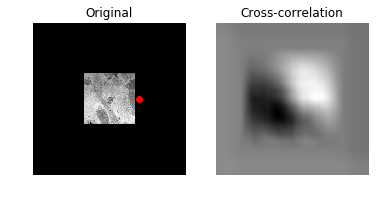

In [262]:
import matplotlib.pyplot as plt
fig, (ax_orig, ax_corr) = plt.subplots(1, 2, figsize=(6, 12))
ax_orig.imshow(face, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_corr.imshow(corr, cmap='gray')
ax_corr.set_title('Cross-correlation')
ax_corr.set_axis_off()
ax_orig.plot(x, y, 'ro')

plt.show()

merge the images given the x,y homography

In [263]:
from math import floor
from PIL import Image

def paste(canvas, paint):
    '''
    Paste an image on to another using masks.
    '''
    h, w = canvas.shape
    p_h, p_w = paint.shape
    nw, nh = (0,0)
    if w < p_w:
        nw = p_w - w
    if h < p_h:
        nh = p_h - h
    output = np.copy(canvas)
    output = np.pad(output, ((0, nh), (0, nw)), 'constant', constant_values=(0,0))
    assert output.shape[0] == paint.shape[0], 'different heights: %d %d'% (output.shape[0], paint.shape[0])
    assert output.shape[1] == paint.shape[1], 'different widths: %d %d' % (output.shape[1], paint.shape[1])
    # mask magic!
    o_mask = np.ma.equal(output, 0)
    output[o_mask] = paint[o_mask] # for places where output is 0: paint.
    return output

In [264]:
half_y = int(temp1.size[0] / 2)
half_x = int(temp1.size[1] / 2)

nx = x - int(p)
ny = y - int(p)

# There is the assumption here that the image is below or right of the reference image
nx = abs(nx - half_x)
ny = abs(ny - half_y)

temp4 = np.pad(np.asarray(temp2, dtype='uint16'), ((ny, 0), (nx, 0)), 'constant', constant_values=(0,0))
im3 = paste(np.asarray(temp1, dtype='uint16'), temp4)

In [265]:
nx, ny

(76, 1)

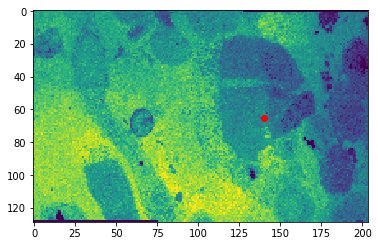

In [266]:
plt.imshow(im3)
axs = plt.gca()
axs.plot(nx+half_x, ny+half_y, 'ro')
plt.show()